In [131]:
import os
import sys

sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

In [132]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_with_target_iapprox5.npy')

In [133]:
dataset.shape

(2860, 16)

In [134]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1

In [135]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [136]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [137]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [138]:
proj = TSNE(n_components=2).fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)

In [139]:
names = [f'domain {i}' for i in range(7)]

In [140]:
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

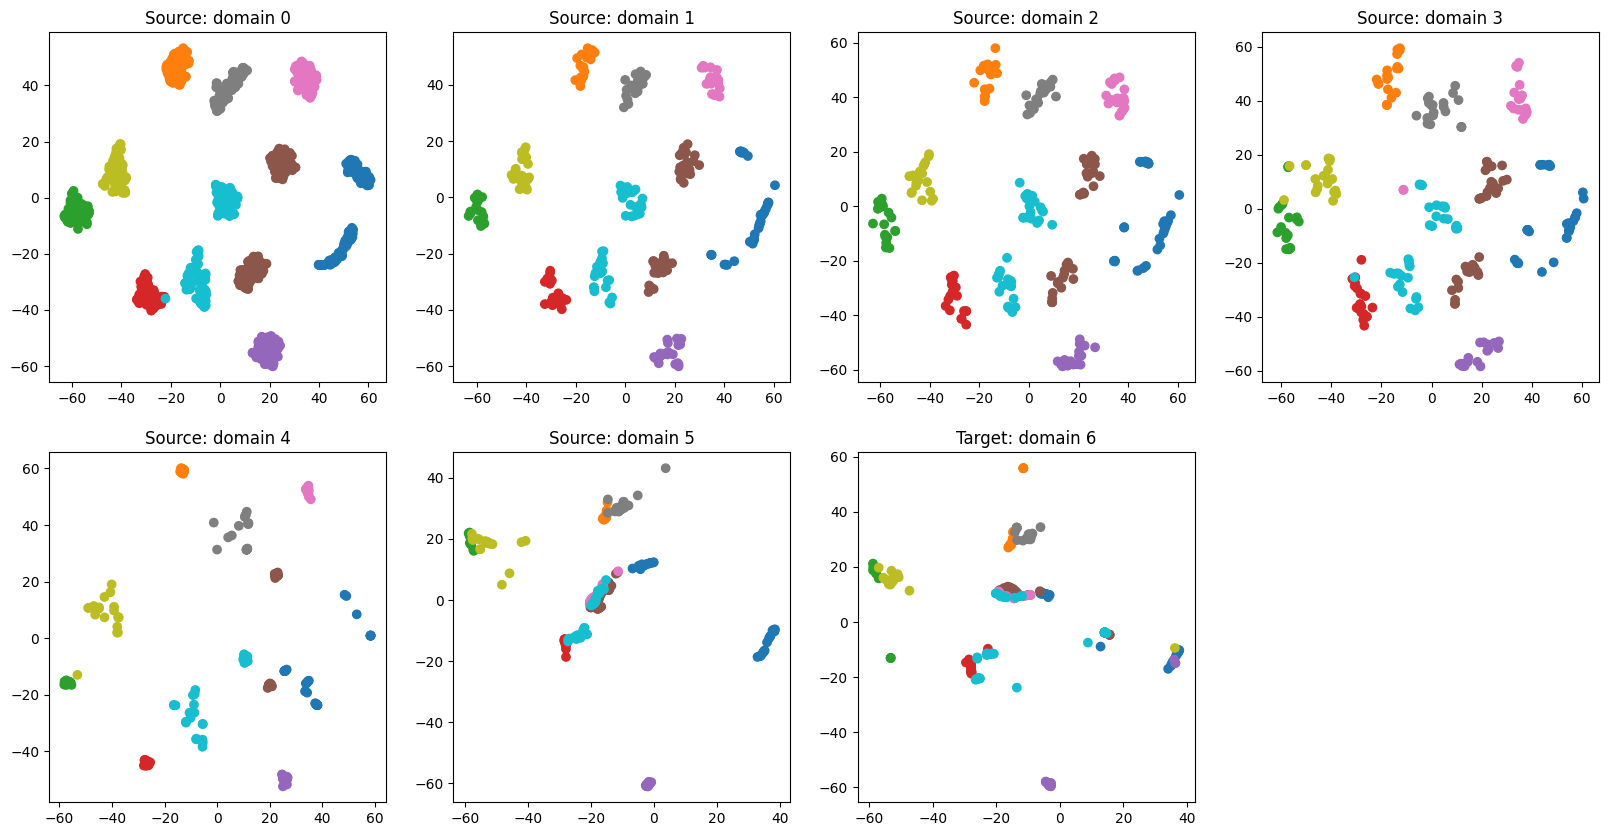

In [141]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

In [142]:
n_samples = 1300
batch_size = 260
n_components = 3

In [143]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [144]:
criterion = JointWassersteinDistance()

In [145]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [146]:
dictionary.fit(Q,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


It 0/40, Loss: 107.58397369384765


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


It 1/40, Loss: 48.086273956298825


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


It 2/40, Loss: 20.39852924346924


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


It 3/40, Loss: 9.43254108428955


100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


It 4/40, Loss: 4.749811840057373


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


It 5/40, Loss: 2.9301700115203855


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


It 6/40, Loss: 2.0499808549880982


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


It 7/40, Loss: 1.5348988533020018


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


It 8/40, Loss: 1.2104344129562377


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


It 9/40, Loss: 0.9993464708328247


100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


It 10/40, Loss: 0.8747302532196044


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


It 11/40, Loss: 0.789428961277008


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


It 12/40, Loss: 0.7359094500541686


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


It 13/40, Loss: 0.710180938243866


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


It 14/40, Loss: 0.6821706771850586


100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


It 15/40, Loss: 0.6640387177467346


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


It 16/40, Loss: 0.6448047995567322


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 17/40, Loss: 0.6259772419929504


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


It 18/40, Loss: 0.5988415837287904


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


It 19/40, Loss: 0.5672813892364502


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


It 20/40, Loss: 0.5153663158416748


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


It 21/40, Loss: 0.47537400722503664


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 22/40, Loss: 0.40638632178306583


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


It 23/40, Loss: 0.3355394542217255


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


It 24/40, Loss: 0.2817939698696137


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


It 25/40, Loss: 0.2662813603878021


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 26/40, Loss: 0.2499490559101105


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


It 27/40, Loss: 0.25457079112529757


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


It 28/40, Loss: 0.2423124819993973


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


It 29/40, Loss: 0.23125183582305908


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


It 30/40, Loss: 0.22782705426216124


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


It 31/40, Loss: 0.22361161112785338


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 32/40, Loss: 0.22546386420726777


100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


It 33/40, Loss: 0.22665634453296662


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


It 34/40, Loss: 0.22416566014289854


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


It 35/40, Loss: 0.21711038053035736


100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


It 36/40, Loss: 0.2226706087589264


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


It 37/40, Loss: 0.20872519612312318


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 38/40, Loss: 0.22289366126060484


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]

It 39/40, Loss: 0.21711622178554535


(0.0, 1.0, 0.0, 1.0)

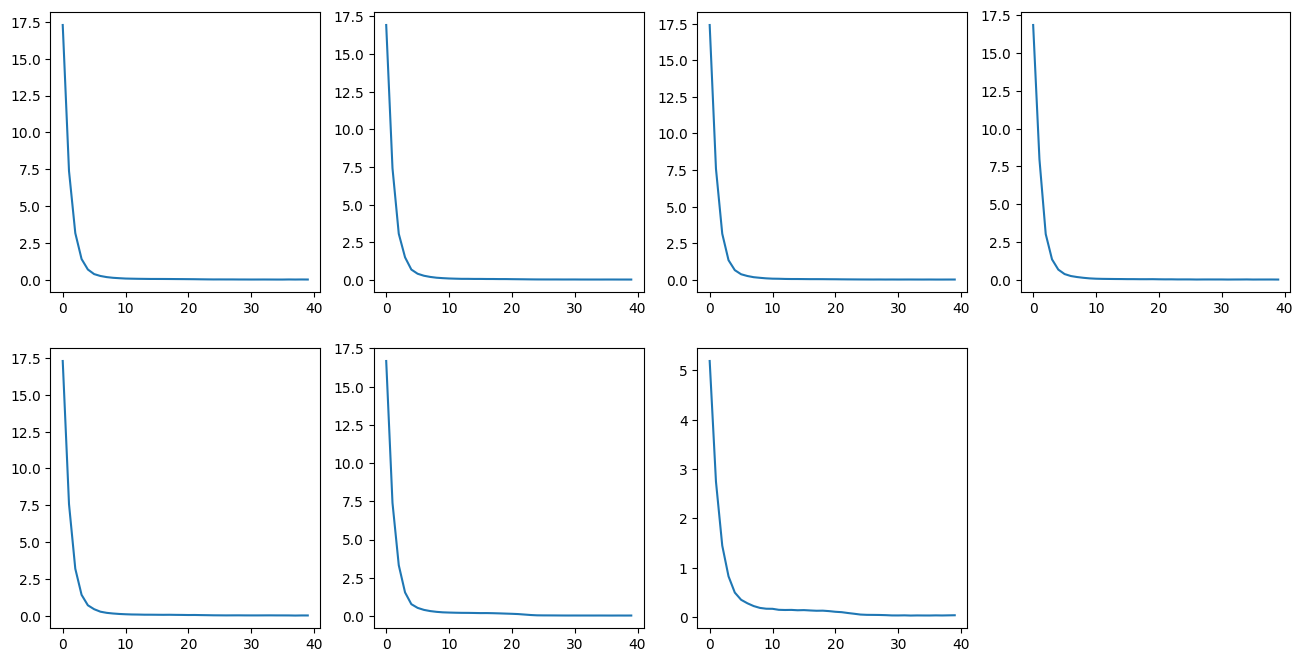

In [147]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, d in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][d])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.08299289457499981, 0.6950971577316523)

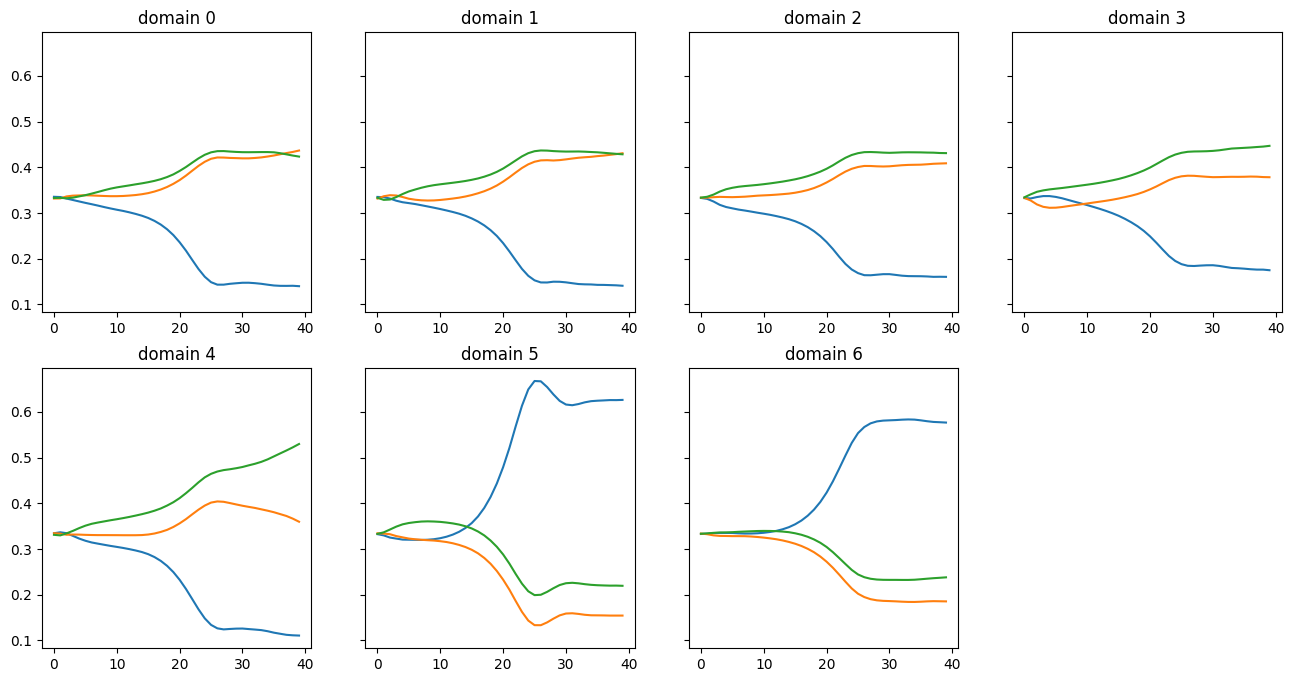

In [148]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [149]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.5764, 0.1855, 0.2381])


In [150]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [151]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.5846153846153846


In [152]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6423076923076924
